Time Series Modeling 

A1. Research Question

What should our revenue prediction be for the upcoming year and is it possible to predict the company's business revenue for the follow - up phase in order for the business to prepare a project to keep clients or grow its customer expansion program? 

A2. Objectives and Goals

By examining the revenue by day for the previous two years in order to pinpoint general trends, seasonality, and other aspects, a predictive model that will anticipate future revenue is to be created. Also employed time series modeling to project the business's daily revenue for the upcoming quarter.

B. Assumptions

 * The time series data ought to remain constant (stationary). It denotes that the series has a normal distribution and that the mean and variance have been stable throughout time. The series shows no patterns and neither a growth nor a contraction. The variation never changes and there is also a consistent autocorrelation

* The error term is randomly distributed. In time series analysis, it is presumpted that the error is uncorrelated.

* The series shouldn't have any outliers. Outliers could produce false outcomes.

* A time series' degree of similarity to a lagged version of itself over successive time intervals is mathematically represented by autocorrelation. A set of current data is compared to a set of previous values using autocorrelation to see whether they are correlated.

In [1]:
from datetime import datetime
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm 
from statsmodels.tsa.arima_model import ARIMA
from scipy import signal
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import joblib

Part III: Data Preparation

In [5]:
dataset = pd.read_csv('teleco_time_series.csv', index_col = 'Date', parse_dates = True)
dataset.head()

,Revenue
Date,
2019-01-01,0.000000
2019-01-02,0.000793
2019-01-03,0.825542
2019-01-04,0.320332
2019-01-05,1.082554


In [6]:
dataset.describe()
dataset.shape

(731, 1)

In [7]:
#Check to see if there are any null or missing values
#Looks like there are no null values since the churn dataset is cleaned prior
check1= dataset.isnull().sum()
check2= dataset.isnull().values.any()
print(check1)
print(check2)

Revenue    0
dtype: int64
False


In [8]:
dataset = dataset.dropna() #Dropping any nulls that the dataset has

In [9]:
#Export the cleaned data to csv file
pd.DataFrame(dataset).to_csv('cleaned_data.csv')

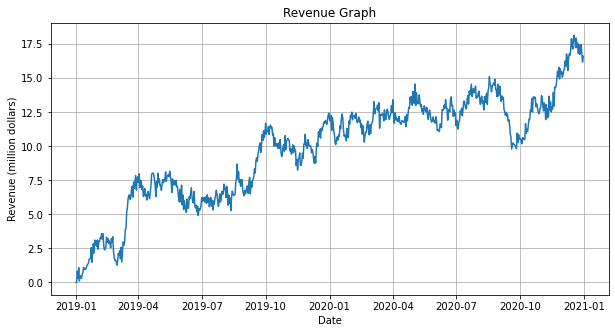

In [10]:
plt.figure(figsize=(10,5))
plt.plot(dataset.Revenue)
plt.title('Revenue Graph')
plt.xlabel('Date')
plt.ylabel('Revenue (million dollars $)')
plt.grid(True)
plt.show()


In [ ]:
rolmean = dataset.rolling(window=12).mean() # window = 12 signifies monthly level
rolstd = dataset.rolling(window=12).std()

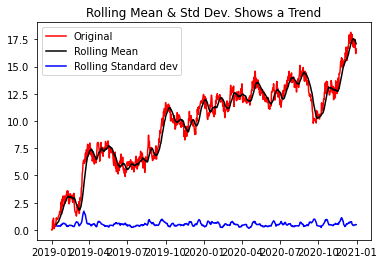

In [13]:
orig = plt.plot(dataset, color='red', label='Original')
means = plt.plot(rolmean, color='black', label='Rolling Mean')
standard_deviation = plt.plot(rolstd, color='blue', label='Rolling Standard dev')
plt.legend(loc='best')
plt.title('Rolling Mean & Std Dev. Shows a Trend')
plt.show(block=False)

As seen in the graph above, neither the mean nor the standard deviation are constant. 

In [14]:
print ('Dickey-Fuller Test: ')

dftest2 = adfuller(dataset['Revenue'], autolag='AIC')
dfoutput2 = pd.Series(dftest2[0:4], index=['Test-Stat','pValue','#Lag','# Obser.'])

for key,value in dftest2[4].items():
	dfoutput2['Crit. Val (%s) '%key] = value # Critical Values should always be more than the test statistic

print(dfoutput2)

Dickey-Fuller Test: 
Test-Stat            -1.924612
pValue                0.320573
#Lag                  1.000000
# Obser.            729.000000
Crit. Val (1%)       -3.439352
Crit. Val (5%)       -2.865513
Crit. Val (10%)      -2.568886
dtype: float64


In [15]:
#If p-value is less than 0.05
if dftest2[1]<= 0.05:
    print('Time series is stationary')
else:
    print('Time series is non-stationary')

Time series is non-stationary


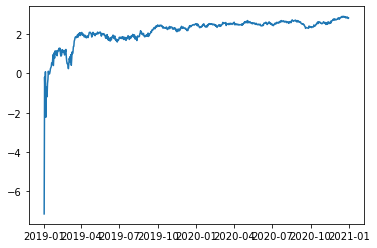

In [16]:
#Taking the log of the data and Graphing it to show if it's stationary
dataset_logScale = np.log(dataset)
plt.plot(dataset_logScale)

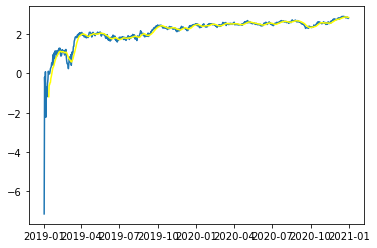

In [18]:
#Calculate Moving Average and Graph Moving Average 
movingAverages2 = dataset_logScale.rolling(window = 12).mean()
movingSTD = dataset_logScale.rolling(window = 12).std()
plt.plot(dataset_logScale)
plt.plot(movingAverages2, color = 'yellow') # even when using the Moving Average, data is still not stationary

Log Scale data is not stationary. So Lets try logScale - Moving Average to see if the data can be stationary.

In [20]:
datasetLogScaleMinusMovingAverage2 = dataset_logScale - movingAverages2
datasetLogScaleMinusMovingAverage2.head(12)                                   
datasetLogScaleMinusMovingAverage2.dropna(inplace=True)

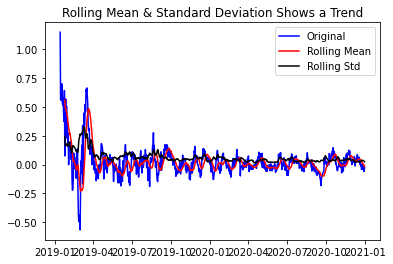

Results of Dickey-Fuller test: 
Test Statistic          -6.477012e+00
p-value                  1.323444e-08
#Lags Used               1.100000e+01
No. of Observations      7.070000e+02
Critical Value (1%)     -3.439633e+00
Critical Value (5%)     -2.865637e+00
Critical Value (10%)    -2.568952e+00
dtype: float64


In [22]:
test_stationarity(datasetLogScaleMinusMovingAverage2)
#test_stationarity function was created previously

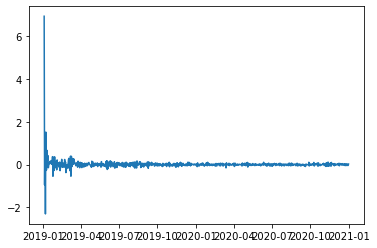

In [23]:
#Interestingly log - shift(1) does yield flattened values 
datasetLogDiffShifting = dataset_logScale - dataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

Another easy way to make the time series stationary! (listed below)

In [24]:
#Make the time series stationary
df_stationary = dataset.diff().dropna()

In [25]:
res = adfuller(df_stationary['Revenue'])

print('Test-stat: ', res[0])
print('p-val: ', res[1])
print('Crit. val: ', res[4])

Test-stat:  -44.874527193876
p-val:  0.0
Crit. val:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [26]:
if res[1]<= 0.05:
    print('time series is stationary')
else:
    print('time series is non-stationary')

time series is stationary


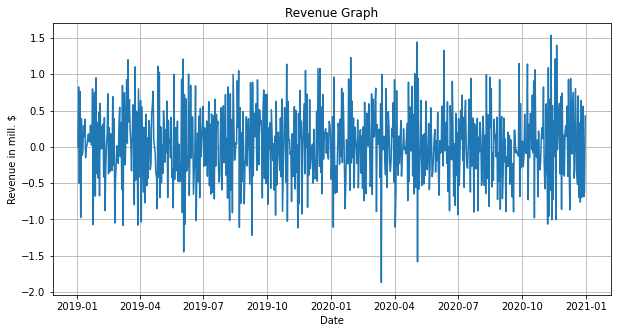

In [27]:
#Visualize the stationary data
plt.figure(figsize=(10,5))
plt.plot(df_stationary.Revenue)
plt.title('Revenue Graph')
plt.xlabel('Date')
plt.ylabel('Revenue in mill. $')
plt.grid(True)
plt.show()

In [28]:
rolmeanzzz = df_stationary.rolling(window=12).mean()
rolstdzzz= df_stationary.rolling(window=12).std()

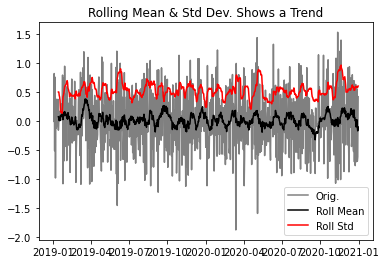

In [29]:
orignal = plt.plot(df_stationary, color='gray', label='Orig.')
meanzzz = plt.plot(rolmeanzzz, color='black', label='Roll Mean')
stdzzz = plt.plot(rolstdzzz, color='red', label='Roll Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Std Dev. Shows a Trend')
plt.show(block=False)

In [31]:
#Split to train and test
x_train = dataset.loc[:'2020-09-30']
x_test = dataset.loc['2020-10-01':]

#Shape and structure of x train and x test values
print('X_train ', x_train.shape)
print('X_test ', x_test.shape)

X_train  (639, 1)
X_test  (92, 1)


Part IV: Model Identification and Analysis

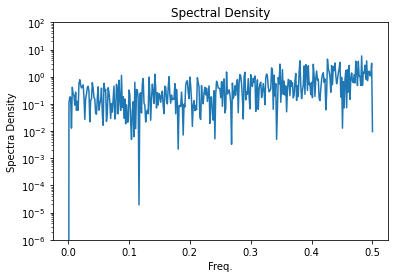

In [33]:
#Spectral Density
f, Pxx_den = signal.periodogram(df_stationary['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Density')
plt.xlabel('Freq.')
plt.ylabel('Spectra Density')
plt.show()
#This graph displays frequencies associated with the autocovariance time domain.
#In close relation to the autocovariance time-domain representation, it represents time seriess' frequency domain.

<AxesSubplot:xlabel='Date'>

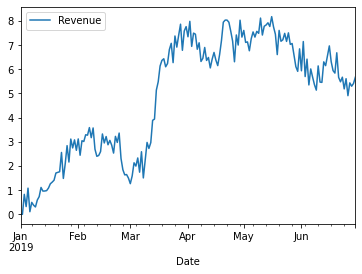

In [34]:
dataset.loc[:'2019-06-30'].plot() #Some seasonality is seen in the data

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

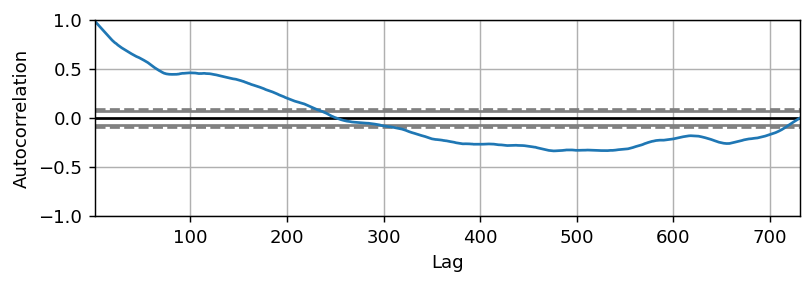

In [37]:
plt.rcParams.update({'figure.figsize':(7,2), 'figure.dpi':130})
autocorrelation_plot(dataset.Revenue.tolist()) #Continue looking for seasonality in the data

Decomposing a time series involves breaking it down into its three main parts: trend, seasonality, and residual. It offers a visual breakdown of the elements and aids in identifying their existence or absence.

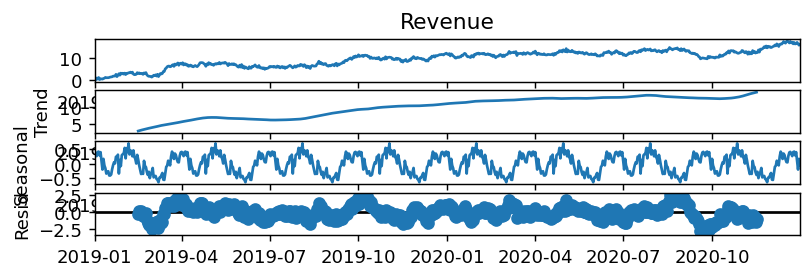

<AxesSubplot:title={'center':'Residuals'}, xlabel='Date'>

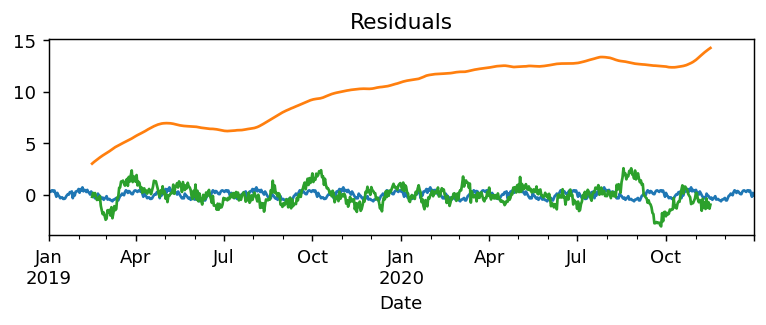

In [38]:
#Perform Decomposition
decomp = seasonal_decompose(dataset['Revenue'], period=90)
decomp.plot() # Plot decomposition 
plt.show() # Check  for seasonality in the data

plt.title('Seasonality')
decomp.seasonal.plot()

#Seasonality describes patterns that, as illustrated below, reoccur frequently over time. This loop may occur every day, 
# every week, every month, every quarter, every year, etc. If the cycle structure repeats with the same frequency, it is regarded as seasonal.


plt.title('Trend')
decomp.trend.plot()
#By looking at the series' overall trend throughout time, one can identify a time series' tendency. It could be going up or down.

plt.title('Residuals')
decomp.resid.plot()


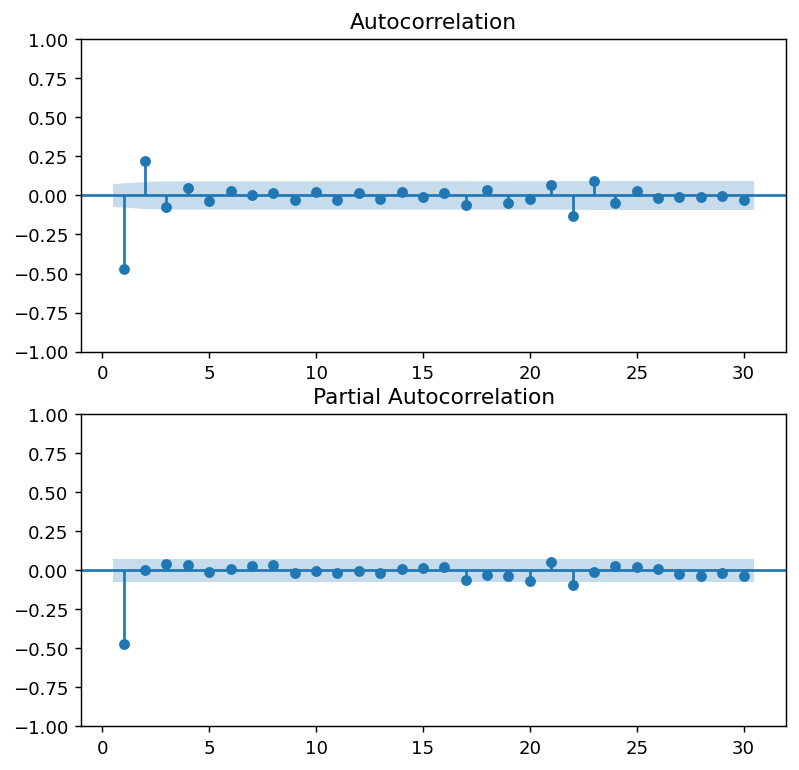

In [39]:

#A plot of a time series' autocorrelation is known as an ACF. The auto correlation demonstrates the cross-period correlation of the data.
#After removing the impact of correlation at shorter lags, a time series' association with its delayed form is known as the PACF.
#Create figure 
fig, (ax1,ax2) = plt.subplots(2,1, figsize = (7,7))
#ACF
plot_acf(df_stationary, lags = 30, zero = False, ax = ax1)
#PACF
plot_pacf(df_stationary, lags = 30, zero = False, ax = ax2)
plt.show()

D2. Identification of an ARIMA Model

In [40]:
best_aic1 = np.inf
best_order1 = None 
best_mdl1 = None
rngz = range(3)


for p in rngz:
    for q in rngz:
        try:
            modelz = SARIMAX(dataset, order=(p,1,q), trend = 'c')
            res = modelz.fit()
            tmp_aic = res.aic
            print(p, q, res.aic, res.bic)
            if tmp_aic < best_aic1:
              best_aic1 = tmp_aic
              best_order1 = (p,q)
              best_mdl1 = tmp_mdl
        except: 
            print(p,q, None, None)
print('\nBest AIC: {:4.5f} | order: {}'. format(best_aic1, best_order1))

#Looks like the Best AIC is 983.12182 and best order is 1,0

0 0 1162.818644246692 1172.0047333149769
0 0 None None
0 1 1019.3694200265691 1033.1485536289963
0 1 None None
0 2 986.5461170204394 1004.9182951570092
0 2 None None
1 0 983.1218204906022 996.9009540930296
1 0 None None
1 1 985.1063519725146 1003.4785301090844
1 2 985.6279606926028 1008.5931833633149
2 0 985.1037013604291 1003.4758794969989
2 1 986.0448019927987 1009.0100246635109
2 2 987.3046225126564 1014.8628897175109

Best AIC: 983.12182 | order: (1, 0)


In [41]:
import statsmodels.api as sm

In [42]:
model = SARIMAX(dataset, order = (1,1,0), seasonal_order = (1,1,0,90))

In [43]:
results_ARIMA = model.fit()

In [ ]:
results_ARIMA.summary()

In [44]:
mae1 = np.mean(np.abs(results_ARIMA.resid))
print("Mean absolute error", mae1)



Mean absolute error 0.4563156351162615


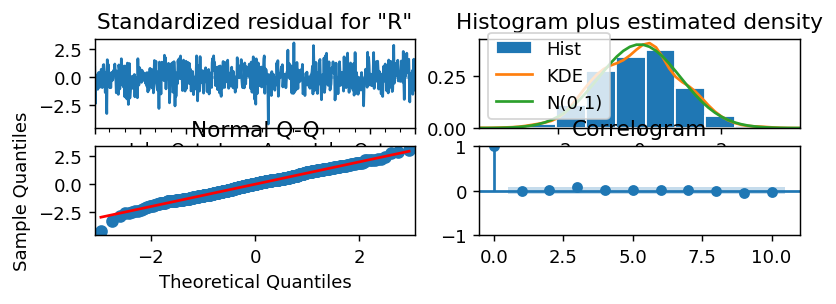

In [45]:
#Create 4 diagostics plots
results_ARIMA.plot_diagnostics().show()

In [46]:
predictionzzz = results_ARIMA.get_prediction(start = -90)
mean_predictionzzz = predictionzzz.predicted_mean
confidence_intervalszzz = predictionzzz.conf_int()
lower_limitszzz = confidence_intervalszzz.loc[:, 'lower Revenue']
upper_limitszzz = confidence_intervalszzz.loc[:, 'upper Revenue']

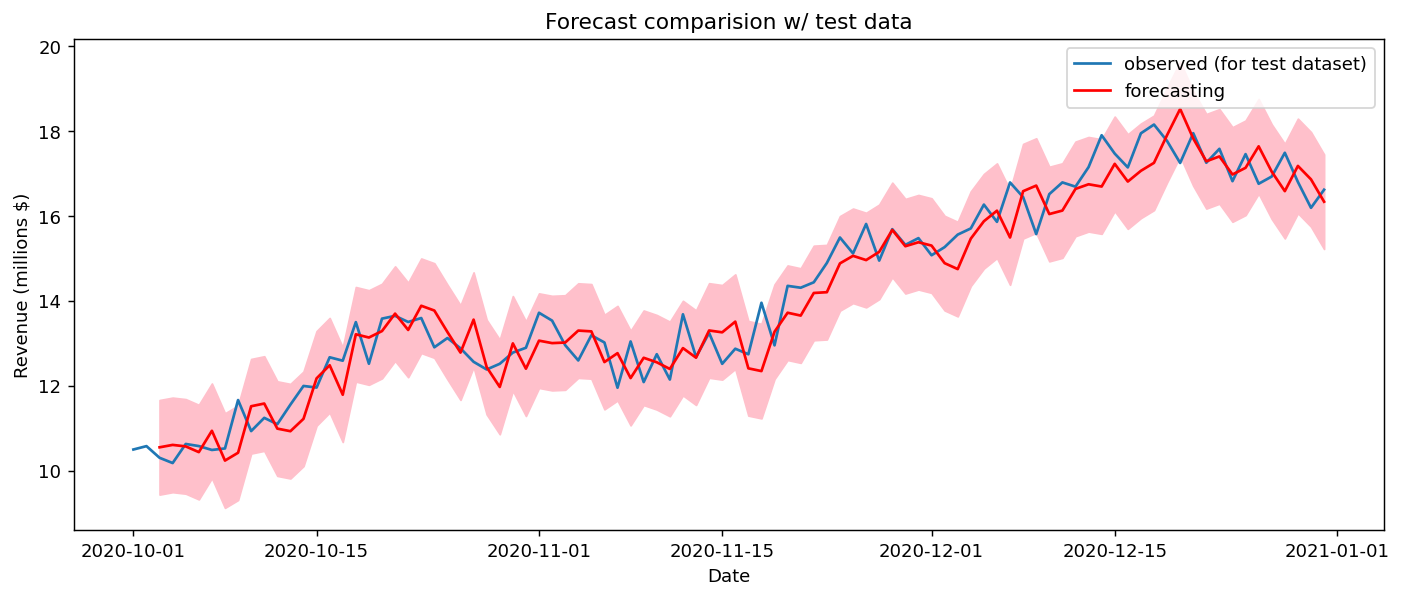

In [47]:
plt.figure(figsize = (13,5))
plt.plot(x_test.index, x_test, label = 'observed (for test dataset)')
#mean predictions
plt.plot(mean_predictionzzz.index, mean_predictionzzz, color = 'r', label = 'forecasting')
#shade area between limits
plt.fill_between(lower_limitszzz.index, lower_limitszzz, upper_limitszzz, color = 'pink')

#showing plot, setting legends and labels
plt.title('Forecast comparision w/ test data')
plt.xlabel('Date')
plt.ylabel('Revenue (millions $)')
plt.legend()
plt.show()

In [50]:
#Forecasting for the next 180 days
diff_forecast1 = results_ARIMA.get_forecast(steps = 180)
mean_forecast123 = diff_forecast1.predicted_mean

In [51]:
#Get confidence intervals for prediction 
confidence_intervalszzz = diff_forecast1.conf_int()
lower_limitszzz = confidence_intervalszzz.loc[:, 'lower Revenue']
upper_limitszzz = confidence_intervalszzz.loc[:, 'upper Revenue']

Part V: Data Summary and Implications

E1a. You must first create the ACF and PACF before you can find an appropriate ARIMA model. Then, run several AR and MA order combinations to determine which model has the lowest AIC score. The graph and code are listed above.

E1b. The forecast's prediction window is one day. Our Time model data represents two years' worth of everyday revenue. Therefore, to forecast income at a day interval, the ARIMA model identifies correlations and seasonality.

E1c. Time model can only predict up to 1 year's worth of future income for a 2-year daily revenue data set. Even more accurate predictions will be those made sooner than one year. More historical data will be needed to make long-term predictions.

E1d. The process of model evaluation begins with the development and fitting of an ARMA(p, q) model. The model i chose had the best AIC. I used Auto-Arima to determine the proper seasonal order. The mean absolute error was roughly 0.46 according to the error metric. Given the quantity of observations in the data, it can be concluded that the error rates are low because the error measure is small and close to 0.

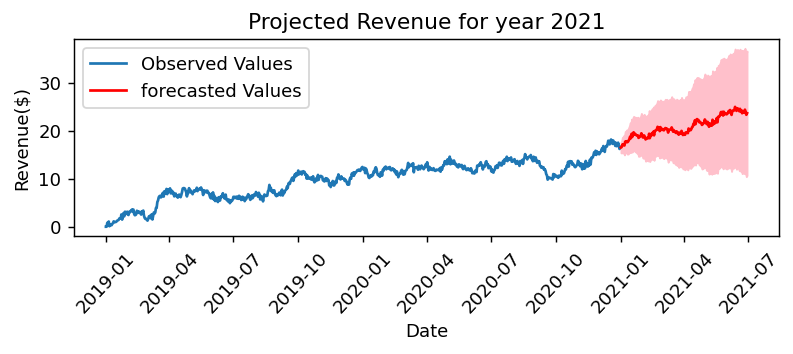

In [53]:
#E2. forecasted revenue data 
plt.plot(dataset.index, dataset, label = 'Observed Values')
#Mean predictions are being plotted
plt.plot(mean_forecast123.index, mean_forecast123, color = 'r', label = 'forecasted Values')
#Shading the area between set limits
plt.fill_between(lower_limitszzz.index, lower_limitszzz, upper_limitszzz, color = 'pink')

#set labels, legends and show plot 
plt.title('Projected Revenue for year 2021')
plt.xlabel('Date')
plt.ylabel('Revenue($)')
plt.xticks(rotation = 47)
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Projected Revenue for 2021'}, xlabel='Date', ylabel='Revenue ($)'>

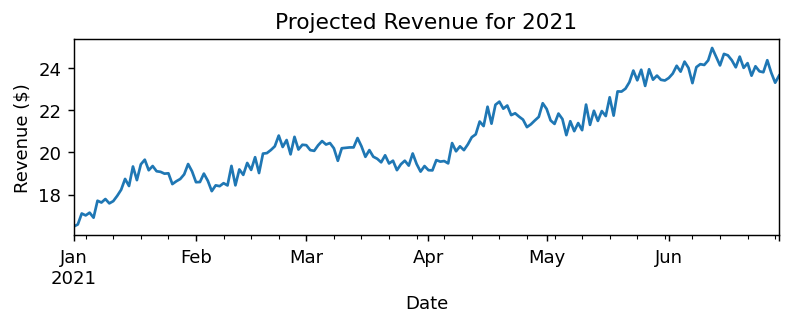

In [54]:
plt.title('Projected Revenue for 2021')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
mean_forecast123.plot()

E3. Recommend a course of action:

* Time series has a good performance accuracy to forecast 180 days future revenue.
* Stakeholders should continue to work toward retaining customers and reducing churn rates. It goes without saying that it is in the company's best interests to offer extra services to clients and enhance their general experience by assisting them in comprehending all of the alternatives available to them as subscribers, not just mobile phone service. Individuals with contracts are less likely to leave the organization, thus we propose spending more on marketing efforts for contract usage and internet services.
